## Libraries and utility functions

In [1]:
import os
import csv
import random
import struct
import pathlib
import numpy as np
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

from typing import Union, Tuple, List

In [2]:
base_path = str(pathlib.Path().absolute())
## images path
mnist_data = base_path+"/data/"

### Utility functions

In [14]:
def read_MNIST(dataset: str="training", path: str="./") -> Union[Tuple[np.ndarray,np.ndarray], np.ndarray]:
    """
    Reads in the MNIST data
    This function allows specification of the part to be read (training/testing/validation)
    Note that if dataset='testing', no labels will be returned
    """
    
    #Figure out the name of the file to load    
    if dataset.lower() == "training":
        file_name_suffix = 'train'
        has_labels = True
    
    elif dataset.lower() == "validation":
        file_name_suffix = 'val'
        has_labels = True

    elif dataset.lower() == "testing":
        file_name_suffix = 'test'
        has_labels = True

    else:
        print("dataset must be 'testing','validation', or 'training'")
        raise ValueError
    
    #Load the appropriate files
    X = np.load(mnist_data+'X'+file_name_suffix+'.npy')
    if has_labels:
        y = np.load(mnist_data+'y'+file_name_suffix+'.npy')
    
    X = np.float64(X).reshape(X.shape[0],-1)
    y = y.flatten().astype('int')
    
    #Return the appropriate data
    if has_labels:
        return X,y
    else:
        return X


def show_MNIST_example(image) -> None:
    """
    Render a given numpy.uint8 array of pixel data as an image.
    """
    image = image[-28**2:]
    image = image.reshape(28,28)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.axis('off')
    plt.show()

Training image
Class: 6


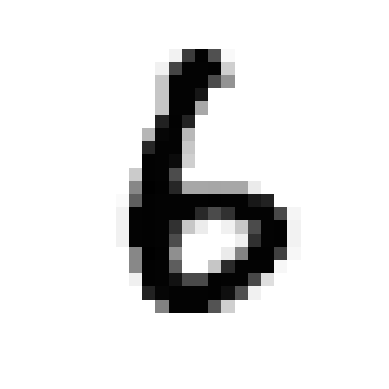

In [15]:
# load the data and visualize a training example
X,y = read_MNIST("training")
print("Training image")
print(f"Class: {y[10]}")
show_MNIST_example(X[10])

X_val,y_val = read_MNIST("validation")
X_test, y_test = read_MNIST("testing")

# let's shuffle the data
np.random.seed(789123)
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]


## Decision Trees (ToDo)

In [16]:
class Node:
    """
    Building block of the Decision Tree.
    """
    left = None  # left child
    right = None  # right child
    index = None  # feature index (what is the feature by which we split)
    val = None  # what's the value at which we split
    # Once you arrive at a leaf Node then we use labels
    is_leaf = True
    label = None
    
    def __init__(self, left=None, right=None, index=None, val=None, is_leaf=True, label=None):
        self.left = left
        self.right = right
        self.val = val
        self.is_leaf = is_leaf
        self.label = label
        
    def classify(self, x):
        # this is a recursive function, following the path to the correct leaf
        if self.is_leaf:
            return self.label
        elif x[self.index] <= self.val:
            return self.left.classify(x)
        elif x[self.index] > self.val:
            return self.right.classify(x)
        
            
    def classify_set(self, X):
        # work on examples in a loop 
        res = []
        for sample in X:
            res.append(self.classify(sample))
        return np.asarray(res)
            
    #useful for debugging (on small trees)
    def print_tree(self) -> None:
        print(f"index = {self.index}, val = {self.val}, leaf = {self.is_leaf}, label = {self.label}, left = {self.left}, right = {self.right}")
        if self.left is not None:
            print("left = ", end="")
            self.left.print_tree()
        if self.right is not None:
            print("right = ", end="")
            self.right.print_tree()

In [17]:
# to classify a leaf node take the mode of the labels that arrive at the leaf
def label_leaf(labels):
    classes, counts = np.unique(labels, return_counts=True)
    return classes[np.argmax(counts)]

In [18]:
def best_split_gini(features, labels, min_split_size=5):
    """
    Given a set of feature values (for a single feature) and the corresponding labels,
    find the split that minimizes the (weighted by size) sum of the Gini indices of the two parts
    Note: the combined Gini index is given by len(L)*G[0]+len(U)*G[1]

    Returns: (tau, G, L, U)
        tau : the threshold to split
        G : 2-tuple with the Gini indices of the two parts
        L, U : indices of the points that go into L and U
    """
    
    # sort the feature values (and permute the labels to match that order)
    order = np.argsort(features)
    x = features[order]
    y = labels[order]
    N = len(x)
    classes = np.unique(labels)
    
    # check if there is nothing to split
    if (x[0]==x[-1]) or (len(classes)==1):
        return None, [np.inf,np.inf], range(N), None    
    
    # freq_u maintains frequencies of labels in the (potential) upper portion of the split,
    # and freq_l in the lower
    
    freq_u = np.zeros(np.max(classes) + 1)
    for c in range(len(freq_u)):
        freq_u[c] = np.mean(labels==c)
    freq_l = np.zeros(np.max(classes) + 1)
    
    # now go over the examples in order of increasing feature value;
    # consider splitting before each index where the value changes
    # rather that computing the Gini index from scratch for every split, we will keep track
    # of the running frequencies (as we traverse the list of examples ordered by feature value)
    # and simply recompute Gini from the frequencies each step (much faster)
    
    gini=dict()
    splits=dict()
    for i in range(N-1):
        # update frequencies
        freq_l[y[i]] += 1/N
        freq_u[y[i]] -= 1/N
        
        if x[i+1] > x[i]: # split here, between i and i+1?
            tau = (x[i+1] + x[i]) / 2.0
            
            gini_l = np.dot(freq_l, 1-freq_l)
            gini_u = np.dot(freq_u, 1-freq_u)
            
            gini[tau] = (i * gini_l + (N-i) * gini_u, gini_l, gini_u)
            splits[tau] = i+1 # index of the first element that goes to U

    # now find the best split
    best_tau = -1
    bestval = np.inf
    for t in gini:
        if gini[t][0] < bestval:
            best_tau = t
            bestval = gini[t][0]
    
    L = order[:splits[best_tau]]
    U = order[splits[best_tau]:]
    
    return best_tau, gini[best_tau][1:], L, U

In [29]:
def split_data(X, y, min_split_size=5, M=None):
    # Find the best way to split the data in X (with labels y) by a single feature
    # Don't split if not enough data given min_split_size (return None), otherwise
    # return a dictionary with the following key/value pairs:
    # 'd' -> the index of the feature in X by which we are splitting;
    # 'tau' -> the threshold at which we are splitting that feature;
    # 'Gini' -> the (weighted) Gini index of the two new leaves; 
        # is this the combined Gini index of this node: len(L)*G[0]+len(U)*G[1] ?
    # 'Gini-parts' -> a 2-tuple (list) of Gini indices of the L and U leaves after the split;
    # 'L' -> indices of the examples in X that go into the lower (left) leaf;
    # 'U' -> same for the upper (right) leaf
    #
    # M specifies the number of features to consider in looking for the best split. If M=None, this means using
    # all the features of X. Otherwise, if say M=50, this means pick 50 features at random and only consider 
    # splitting by these features.
    
    if X.shape[0] < min_split_size:
        return None
    num_feat = len(X[0])
    feat_indicies = list(range(num_feat))
    if M != None:
        feat_indicies = random.choices(list(range(num_feat)), k=M)
    
    best_gini = np.inf
    best_d = None
    best_tau = None
    best_gini_tup = None
    best_L = None
    best_U = None
    
    for j in feat_indicies:
        x = X[:, j]
        tau, G, L, U = best_split_gini(x, y)
        if tau == None:
            continue

        cur_gini = (G[0] * len(L) + G[1] * len(U)) / (len(L) + len(U))
        if cur_gini < best_gini:
            best_gini = cur_gini
            best_d = j
            best_tau = tau
            best_L = L
            best_U = U
            best_gini_tup = G
    
    if best_tau == None:
        return None
    
    return {
        'd': best_d,
        'tau': best_tau, 
        'Gini': best_gini,
        'Gini-parts': best_gini_tup,
        'L': best_L, 'U': best_U
    }
    

In [25]:
def grow_tree(
    root, 
    data, 
    labels, 
    depth, 
    max_depth=np.inf, 
    min_split_size=1, 
    M=None):
    # this takes root (a node associated with data/labels, and existing at the given depth)
    # and builds a tree rooted at that node, not to exceed the given max_depth
   
    # take a look at Node.classify() to get a better sense how the recursive nature of the tree
    # lets you "drop a point down the tree" and assign a label once you are in the leaf

    if (depth == max_depth):
        no_split=True # we are done, no more splitting below this node
    else:
        best_split = split_data(data, labels, min_split_size,M)
        if best_split==None: # for some reason the splitting code refused to split
            no_split=True
        else: # splitting!
            no_split=False
            # COMPLETE CODE: assign values to .index, .val, .is_leaf
            root.val = best_split['tau']
            root.index = best_split['d']
            root.is_leaf = False
            
            root.left = grow_tree(Node(), data[best_split['L']], labels[best_split['L']], depth+1, max_depth,min_split_size,M)
            root.right = grow_tree(Node(), data[best_split['U']], labels[best_split['U']], depth+1, max_depth,min_split_size,M)
            
            
    if no_split: # this is going to be a leaf, let's record this fact and assign it a label to predict
        root.is_leaf = True
        root.label = label_leaf(labels)
         
    return root

In [26]:
def build_tree(data, labels, max_depth=np.inf, min_split_size=1, M=None):
    root=Node()
    tree=grow_tree(root,
                   data,
                   labels,
                   depth=0, # this will "signal" to the tree growing function that this is the root
                   max_depth=max_depth,
                   min_split_size=min_split_size,
                   M=M)
    return tree

In [27]:
# tree = build_tree(X, y, max_depth=10, min_split_size=3, M=None) # may take a few minutes
tree = build_tree(X, y, max_depth=2, min_split_size=3, M=None) # may take a few minutes

### Training and validation accuracy for the tree (ToDo)

- **Compute** training and validation accuracies

- **Report** training and validation set accuracies of a single tree, 
    - with **hyperparameters** (max tree depth and minimum size of a leaf) tuned as you see fit (make sure to describe how you tuned them and include the code and output from the process in the notebook). 

In [31]:
def test_val_acc(max_depth, min_split_size):
    tree = build_tree(X, y, max_depth=max_depth, min_split_size=min_split_size, M=None)
    res = np.array(tree.classify_set(X_val))
    num_correct = np.sum(res == y_val)
    return num_correct / len(y_val)

for max_depth in [5, 10, 20]:
    for min_split_size in [3, 5]:
        print("acc is", test_val_acc(max_depth, min_split_size))

# Best max_depth is 10
# Best min_split_size is 5
# Best val acc is 0.847

acc is 0.6400666666666667
acc is 0.6400666666666667
acc is 0.847
acc is 0.847
acc is 0.8432666666666667
acc is 0.8442666666666667


### Test accuracy (ToDo)

- **Compute and report** the results on test set, for the model built with the chosen values – please don’t be tempted to evaluate the model on test more than once, so be sure you are done with the tuning!

In [50]:
def test_acc(max_depth, min_split_size):
    tree = build_tree(X, y, max_depth=max_depth, min_split_size=min_split_size, M=None)
    res = np.array(tree.classify_set(X_test))
    num_correct = np.sum(res == y_test)
    return num_correct / len(y_test)

best_depth = 10
best_split_size = 5

tree = build_tree(X, y, max_depth=best_depth, min_split_size=best_split_size, M=None)
print("test acc", test_acc(best_depth, best_split_size))

# Test acc is 0.8521

test acc 0.8521


## Prune the Tree (ToDo)

- **Question 4 is a bonus question**. You are encouraged to do it

- Add the code for pruning a tree
- Report the accuracy of the CART tree (with pruning) using hyperparameters (including λ) tuned as you see fit, on the test set; 
- Compare it to the result with the unpruned tree, and comment on the difference, if any.

# Bagging Section

In [35]:
# Helper functions for running bagging ensembles on data
def apply_ensemble(trees, data, C=10):
    """Returns the labels after applying the ensemble"""
    res = np.array([tree.classify_set(data) for tree in trees])
    yhat = np.zeros(res.shape[1])
    for i in range(res.shape[1]):
        yhat[i]=np.argmax(np.bincount(res[:,i]))
    return yhat.astype(int)

def evaluate_ensemble(trees, data, labels):
    """Returns the accuracy of the ensemble"""
    return np.mean(apply_ensemble(trees, data) == labels)

### Create ensemble (ToDo)

In [32]:
# Bagging
def create_ensemble(X, y, max_depth=10, min_split_size=1, num_trees=5, M_fraction=0.5):
    """
    M_fraction gives M as a fraction of d (# of features in X)
    """
    N, d = X.shape
    assert 0 < M_fraction < 1.0
    M = int(d*M_fraction)  # compute the actual M (number of features to consider in each node)
    
    trees = []
    for _ in tqdm(range(num_trees)): # this will show progress bar as you build the forest
        
        # COMPLETE CODE HERE -- construct tree
        indices = np.random.randint(N, size=N)
        tree = build_tree(X[indices], y[indices], max_depth, min_split_size, M)
        trees.append(tree)
        
    return trees

#### NB: This step takes a while

In [33]:
ensemble = create_ensemble(X, y, max_depth=15, min_split_size=5, num_trees=30, M_fraction=0.05)

100%|██████████| 30/30 [6:58:39<00:00, 837.32s/it]   


### Train/Validation Accuracy (ToDo)

- **Compute** the training and validation accuracy

- **Report** the training and validation set accuracies of your ensemble. You should aim to get at least **90%** validation accuracy.
- **Plot** the val accuracy as a function of ensemble size

In [38]:
# Training acc
print("acc on training set", evaluate_ensemble(ensemble, X, y))
print("acc on val set", evaluate_ensemble(ensemble, X_val, y_val))

# Tuning for M
for m in [0.01, 0.1, 0.15, 0.2]:
    ensemble = create_ensemble(X, y, max_depth=15, min_split_size=5, num_trees=30, M_fraction=m)
    print("m", m, "acc", evaluate_ensemble(ensemble, X_val, y_val))

# m 0.01 acc 0.9374666666666667
# m 0.1 acc 0.9545333333333333
# m 0.15 acc 0.9552
# m 0.2 acc 0.9552

acc on training set 0.9971333333333333
acc on val set 0.952


100%|██████████| 30/30 [05:51<00:00, 11.72s/it]


m 0.01 acc 0.9362666666666667


 10%|█         | 3/30 [03:59<35:51, 79.69s/it]

### Test Accuracy (ToDo)
- **Compute and report** the results of your ensemble on the test set. Again, don’t do it more than once!

In [42]:
# Test acc with best m
ensemble = create_ensemble(X, y, max_depth=15, min_split_size=5, num_trees=30, M_fraction=0.2)
print("acc on test set", evaluate_ensemble(ensemble, X_test, y_test))

100%|██████████| 30/30 [37:08<00:00, 74.27s/it]


acc on test set 0.955


## Effect of the size of your ensemble (ToDo)

- **Show the effect of the size of your ensemble as follows**: 
    - Let T be the number of trees in your ensemble. 
    - For t = 1, . . . , T 
        - **Compute** the validation set accuracy of the partial ensemble consisting of trees 1, . . . , t
        - **Plot** this as a function of t. 
- Discuss what this tells you and how it may inform tuning T.

*Advice: Do not re-run the creation of the forest for T = 1, 2, . . .! rather, take your existing ensemble and compute the accuracy of the partial ensembles consisting of only the first tree; the first two trees; etc.*

In [48]:
# Test different sizes of ensemble
sizes = list(range(len(ensemble)))
acc = []
for t in sizes:
    partial_ensemble = ensemble[:t+1]
    val_acc = evaluate_ensemble(partial_ensemble, X_val, y_val)
    acc.append(val_acc)

[0.7908, 0.7895333333333333, 0.8598666666666667, 0.8908, 0.9035333333333333, 0.9102, 0.9186, 0.9259333333333334, 0.9315333333333333, 0.9338666666666666, 0.9377333333333333, 0.9400666666666667, 0.9405333333333333, 0.9422666666666667, 0.9436666666666667, 0.9456, 0.9462666666666667, 0.9466, 0.9482666666666667, 0.9482, 0.9489333333333333, 0.9490666666666666, 0.9506, 0.9506666666666667, 0.9504666666666667, 0.952, 0.9518, 0.9524, 0.9522666666666667, 0.9528]


Text(0, 0.5, 'Val Accuracy')

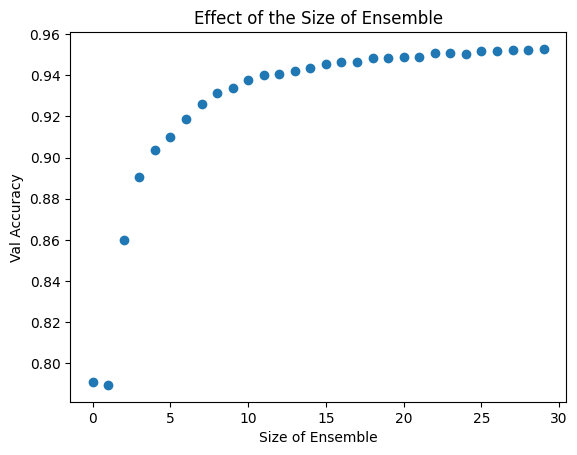

In [49]:
# Plot size vs acc
plt.scatter(sizes, acc)
plt.title("Effect of the Size of Ensemble")
plt.xlabel("Size of Ensemble")
plt.ylabel("Val Accuracy")

## Discuss how the plot inform tuning the size of ensemble (ToDo)
- Overall, the bigger the size of the ensemble, the better the validation accurary.
- At first, val accuracy increases significantly with every tree added to the ensemble. Because each tree has high variance, so averaging a high variance tree with a new tree will ameliorate over-fitting and produce a great improvement in val accuracy. 
- Yet, when the ensemble size reaches around 15, the increase in accuracy starts to plateau, because the current ensemble already achieved a moderate variance. 
- Therefore, a good choice of size might be around 15, so that the ensemble creation time would be reduced. 

